In [4]:
from torchtext.data.utils import get_tokenizer


In [5]:
from datasets import load_dataset

# Load the dataset (raw text version)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_iter = dataset['train']['text']


In [6]:
# subset
# train_iter = dataset['train'].select(range(1000))['text']


In [7]:
type(train_iter)

list

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import DataLoader, Dataset


In [9]:

# 1. Load  WikiText
tokenizer = get_tokenizer('basic_english')


In [48]:

# Build vocabulary
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = {word: i for i, (word, _) in enumerate(counter.items())}
vocab_size = len(vocab)


In [11]:
len(vocab)

66057

In [12]:
# example
first_key = next(iter(vocab))
first_value = vocab[first_key]

print(f"First key: {first_key}, First value: {first_value}")

First key: =, First value: 0


In [13]:
# save vocab into json

import json

# Save vocab
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab, f, ensure_ascii=False, indent=2)

# To load it back later:
#with open("vocab.json", "r", encoding="utf-8") as f:
#    vocab = json.load(f)


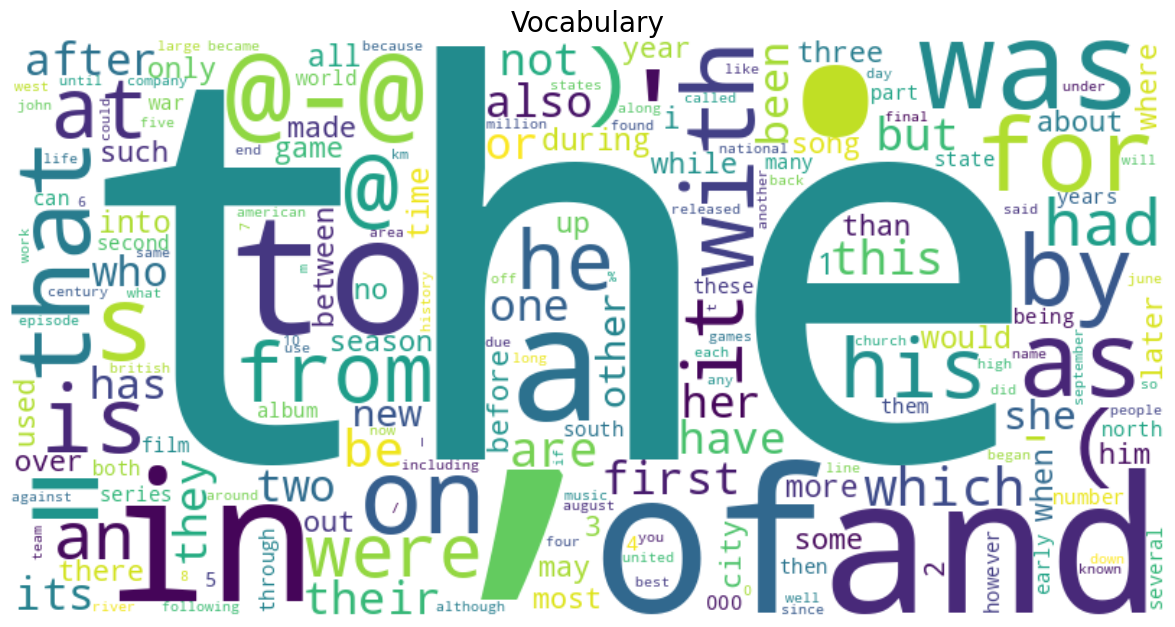

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Vocabulary", fontsize=20)
plt.show()


In [15]:

CONTEXT_SIZE = 2
data = []
for line in train_iter:
    tokens = tokenizer(line)
    if len(tokens) < 2 * CONTEXT_SIZE + 1:
        continue  # skip short lines
    for i in range(CONTEXT_SIZE, len(tokens) - CONTEXT_SIZE):
        context = [tokens[j] for j in range(i - CONTEXT_SIZE, i)] + \
                  [tokens[j] for j in range(i + 1, i + CONTEXT_SIZE + 1)]
        target = tokens[i]
        data.append((context, target))


class CBOWDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_idxs = torch.tensor([self.vocab[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor(self.vocab[target], dtype=torch.long)
        return context_idxs, target_idx

dataset = CBOWDataset(data, vocab)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


# 2. Define model
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    def forward(self, context_idxs):
        embeds = self.embeddings(context_idxs)
        avg_embeds = embeds.mean(dim=1)
        out = self.linear(avg_embeds)
        return out
    def get_embedding(self, words, vocab):
        idxs = torch.tensor([vocab[w] for w in words if w in vocab], dtype=torch.long)
        return self.embeddings(idxs)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_dim = 300
model = CBOWModel(vocab_size, embedding_dim).to(device)

In [17]:
# Load
embeddings = torch.load("embeddings-300dim-20e.pt",  map_location='cpu')

In [18]:
# 4. Get embeddings for a string
def get_string_embedding(model, input_string, vocab):
    tokens = tokenizer(input_string)
    with torch.no_grad():
        # Get the device of the model's embedding layer
        device = next(model.parameters()).device
        # Convert tokens to indices and move to the correct device
        idxs = torch.tensor([vocab[w] for w in tokens if w in vocab], dtype=torch.long, device=device)
        embedding = model.embeddings(idxs)
    return embedding


In [19]:

# Example embedding
embedding = get_string_embedding(model, "hacker news", vocab)
print(embedding)

tensor([[-4.6941e-01, -2.5536e-01,  1.3898e+00, -3.2558e-01, -1.1581e+00,
         -1.3790e+00, -1.6154e+00,  1.6708e+00, -9.0336e-01, -9.4512e-02,
          1.5698e+00, -6.7381e-01,  7.7827e-01, -1.5001e+00, -1.3750e+00,
          1.0308e+00,  5.0555e-03,  1.1892e+00,  4.7847e-01,  6.3369e-01,
          2.1420e-03, -6.1839e-01, -1.9843e-01,  1.7851e-01,  1.8870e-02,
         -2.1164e+00,  2.0169e+00,  1.2272e+00, -6.5161e-01, -2.7308e-01,
          3.1108e-01, -9.4035e-01, -1.3700e-01,  2.8498e-02,  2.6898e-01,
          6.0856e-01,  2.5130e-01, -7.6898e-02, -1.9823e-01,  1.3459e-01,
          8.5653e-01, -4.2228e-01,  1.7769e+00,  8.1568e-02,  3.3173e-01,
         -9.6859e-01, -1.0224e+00,  8.6844e-01, -8.6008e-02,  5.5261e-01,
         -9.0155e-01, -2.4806e-02, -6.5397e-01,  7.9216e-02,  5.3046e-01,
          2.4807e-01, -1.2416e+00,  2.0994e-01, -8.2759e-01, -1.6941e-01,
         -4.2706e-02,  2.2774e-01, -8.4291e-01,  1.4366e+00, -3.9807e-01,
         -6.2049e-01, -2.2896e-01, -4.

---

In [20]:
word = "computer"
word_idx = vocab.get(word)
if word_idx is None:
    raise ValueError(f"'{word}' not in vocabulary.")

In [21]:
from torch.nn.functional import cosine_similarity

computer_embedding = embeddings[word_idx].unsqueeze(0)  # Shape [1, embedding_dim]

# Compute cosine similarity for all other words
similarities = cosine_similarity(computer_embedding, embeddings)  # Shape [vocab_size]

In [22]:
# Exclude the word itself by setting its similarity to -inf
similarities[word_idx] = float('-inf')

# Get top N most similar word indices
top_n = 10
top_indices = torch.topk(similarities, top_n).indices.tolist()

# Build reverse vocab (index to word)
idx_to_word = {idx: word for word, idx in vocab.items()}

# Decode indices to words
top_words = [idx_to_word[idx] for idx in top_indices]
print(f"Top {top_n} words most similar to '{word}':")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {idx_to_word[idx]} (similarity: {similarities[idx]:.4f})")

Top 10 words most similar to 'computer':
1. jade (similarity: 0.2586)
2. boldest (similarity: 0.2528)
3. fouke (similarity: 0.2361)
4. imperative (similarity: 0.2328)
5. etiquette (similarity: 0.2229)
6. tegami (similarity: 0.2193)
7. azzam (similarity: 0.2178)
8. mesas (similarity: 0.2150)
9. whitlock (similarity: 0.2150)
10. witenagemot (similarity: 0.2147)


---
Analogy eval

In [ ]:
# Load Thomas' full wiki model
embeddings = torch.load("embeddings-300dim-20e.pt",  map_location='cpu')

word_to_ix = vocab
ix_to_word = {i: w for w, i in word_to_ix.items()}

def get_embedding(word):
    if word in word_to_ix:
        return embeddings[word_to_ix[word]]
    return None


# Analogy test
def analogy_test_pytorch(word_to_ix, ix_to_word, embeddings, analogy_questions):
    print("\n--- Analogy Test ---")
    for a, b, c, expected_d in analogy_questions:
        emb_a = get_embedding(a)
        emb_b = get_embedding(b)
        emb_c = get_embedding(c)

        if all([emb_a is not None, emb_b is not None, emb_c is not None]):
            analogy_vector = emb_b - emb_a + emb_c

            # Normalize analogy_vector
            analogy_vector = analogy_vector / (analogy_vector.norm() + 1e-8)

            max_similarity = -1
            best_word = None

            for word, idx in word_to_ix.items():
                if word in [a, b, c]:
                    continue

                word_embedding = embeddings[idx]
                word_embedding = word_embedding / (word_embedding.norm() + 1e-8)

                similarity = torch.dot(analogy_vector, word_embedding).item()

                if similarity > max_similarity:
                    max_similarity = similarity
                    best_word = word

            print(f"'{a}' is to '{b}' as '{c}' is to '{best_word}' (Expected: '{expected_d}')")
        else:
            print(f"Skipping analogy '{a}' is to '{b}' as '{c}' is to '{expected_d}' due to missing word(s).")

# ------------------------------------------
# Sample Analogy Questions
# ------------------------------------------
analogy_questions = [
    ("king", "man", "woman", "queen"),
    ("walk", "walking", "swim", "swimming"),
    ("london", "england", "paris", "france"),
    ("great", "greater", "good", "better"),
    ("big", "biggest", "small", "smallest"),
    ("apple", "iphone", "google", "android"),
    ("microsoft", "windows", "apple", "macos"),
    ("code", "programming", "data", "analysis"),
    ("new", "update", "old", "legacy"),
    ("startup", "founder", "company", "ceo"),
    ("bitcoin", "cryptocurrency", "dollar", "fiat")
]

# Test Thomas' full wiki model
analogy_test_pytorch(word_to_ix, ix_to_word, embeddings, analogy_questions)



--- Analogy Test ---
'king' is to 'man' as 'woman' is to 'cleanliness' (Expected: 'queen')
'walk' is to 'walking' as 'swim' is to 'csr' (Expected: 'swimming')
'london' is to 'england' as 'paris' is to 'nāsti' (Expected: 'france')
'great' is to 'greater' as 'good' is to '-itis' (Expected: 'better')
'big' is to 'biggest' as 'small' is to 'composing' (Expected: 'smallest')
'apple' is to 'iphone' as 'google' is to 'indians' (Expected: 'android')
'microsoft' is to 'windows' as 'apple' is to 'mentz' (Expected: 'macos')
'code' is to 'programming' as 'data' is to 'julietta' (Expected: 'analysis')
'new' is to 'update' as 'old' is to 'devising' (Expected: 'legacy')
'startup' is to 'founder' as 'company' is to 'injury' (Expected: 'ceo')
Skipping analogy 'bitcoin' is to 'cryptocurrency' as 'dollar' is to 'fiat' due to missing word(s).


In [ ]:
# Umut's CBOW model
checkpoint = torch.load("../Ben & Umut - Tokeniser/umuts_cbow_full.pth")
word_to_ix = checkpoint['word_to_ix']
ix_to_word = {i: word for word, i in word_to_ix.items()}
vocab_size = len(word_to_ix) 

# Run the test on Umut's CBOW model
analogy_test_pytorch(word_to_ix, ix_to_word, embeddings, analogy_questions)



--- Analogy Test ---
'king' is to 'man' as 'woman' is to 'yoit' (Expected: 'queen')
'walk' is to 'walking' as 'swim' is to 'gguf' (Expected: 'swimming')
'london' is to 'england' as 'paris' is to 'royalty' (Expected: 'france')
'great' is to 'greater' as 'good' is to 'francisco' (Expected: 'better')
'big' is to 'biggest' as 'small' is to 'mergers' (Expected: 'smallest')
'apple' is to 'iphone' as 'google' is to 'haptic' (Expected: 'android')
'microsoft' is to 'windows' as 'apple' is to 'charles' (Expected: 'macos')
'code' is to 'programming' as 'data' is to '1943' (Expected: 'analysis')
'new' is to 'update' as 'old' is to 'ultralong' (Expected: 'legacy')
'startup' is to 'founder' as 'company' is to 'uas' (Expected: 'ceo')
'bitcoin' is to 'cryptocurrency' as 'dollar' is to 'sqlite' (Expected: 'fiat')


In [47]:
# Load embeddings and vocab (again - just to be sure)
embeddings = torch.load("../score_prediction/embeddings-w2-200titles-300dim-10e.pt", map_location='cpu')

with open("../score_prediction/vocab-w2-200titles.json", "r", encoding="utf-8") as f:
   raw = json.load(f)

word_to_ix = { word: int(idx_str) - 1
               for word, idx_str in raw.items() }
ix_to_word = {int(i): w for w, i in word_to_ix.items()}
vocab_size = len(word_to_ix)

# Run the test on Thomas' CBOW model
analogy_test_pytorch(word_to_ix, ix_to_word, embeddings, analogy_questions)


--- Analogy Test ---
'king' is to 'man' as 'woman' is to '750' (Expected: 'queen')
'walk' is to 'walking' as 'swim' is to 'asclepius' (Expected: 'swimming')
'london' is to 'england' as 'paris' is to 'eliot' (Expected: 'france')
'great' is to 'greater' as 'good' is to 'npr' (Expected: 'better')
'big' is to 'biggest' as 'small' is to 'porch' (Expected: 'smallest')
Skipping analogy 'apple' is to 'iphone' as 'google' is to 'android' due to missing word(s).
'microsoft' is to 'windows' as 'apple' is to 'easternmost' (Expected: 'macos')
'code' is to 'programming' as 'data' is to 'provides' (Expected: 'analysis')
'new' is to 'update' as 'old' is to 'odile' (Expected: 'legacy')
'startup' is to 'founder' as 'company' is to 'shipments' (Expected: 'ceo')
Skipping analogy 'bitcoin' is to 'cryptocurrency' as 'dollar' is to 'fiat' due to missing word(s).
